# ABS Retail Turnover 8501

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Some-plotting-inputs" data-toc-modified-id="Some-plotting-inputs-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Some plotting inputs</a></span></li><li><span><a href="#Plotting-code" data-toc-modified-id="Plotting-code-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plotting code</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib
import calendar

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    find_id,
    recalibrate_series,
    clear_chart_dir,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '8501'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)
clear_chart_dir(CHART_DIR)

## Get data from ABS

In [3]:
retail_catalogue_id = '8501'
source, CHART_DIR, META_DATA = get_fs_constants(retail_catalogue_id)

retail_dict = get_ABS_meta_and_data(catalogue_id)
if retail_dict is None:
    sys.exit(-1)
retail_meta = retail_dict[META_DATA]

cpi_catalogue_id = '6401'
cpi_dict = get_ABS_meta_and_data(cpi_catalogue_id)
if cpi_dict is None:
    sys.exit(-1)
cpi_meta = cpi_dict[META_DATA]

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Some plotting inputs

In [4]:
index_map = {
    # retail turnover: cpi index,
    'Food retailing': 'Food and non-alcoholic beverages',
    'Household goods retailing': 'Furnishings, household equipment and services',
    'Clothing, footwear and personal accessory': 'Clothing and footwear',
    'Department stores': 'All groups CPI', 
    'Other retailing': 'All groups CPI',
    'Cafes, restaurants and takeaway food': 'All groups CPI',
    'Total (Industry)': 'All groups CPI',
}

FROM_DATE = '2017-01-01'
LIN_REGRESS = '2020-01-01'

retail_table = '1'
retail_type = 'Seasonally Adjusted'
retail_df = retail_dict[retail_table]

cpi_table = '4'
cpi_df = cpi_dict[cpi_table]

table_col = 'Table'
did_col = 'Data Item Description'
type_col = 'Series Type'

### Plotting code

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     164.4
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           8.73e-15
Time:                        23:00:46   Log-Likelihood:                 45.700
No. Observations:                  37   AIC:                            -87.40
Df Residuals:                      35   BIC:                            -84.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8765      0.023    423.640      0.0

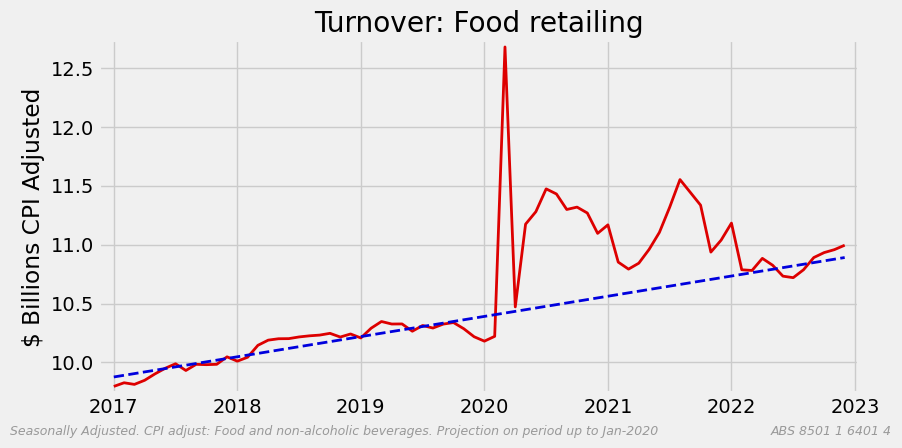

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     25.99
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           1.19e-05
Time:                        23:00:46   Log-Likelihood:                 59.243
No. Observations:                  37   AIC:                            -114.5
Df Residuals:                      35   BIC:                            -111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3167      0.016    267.003      0.0

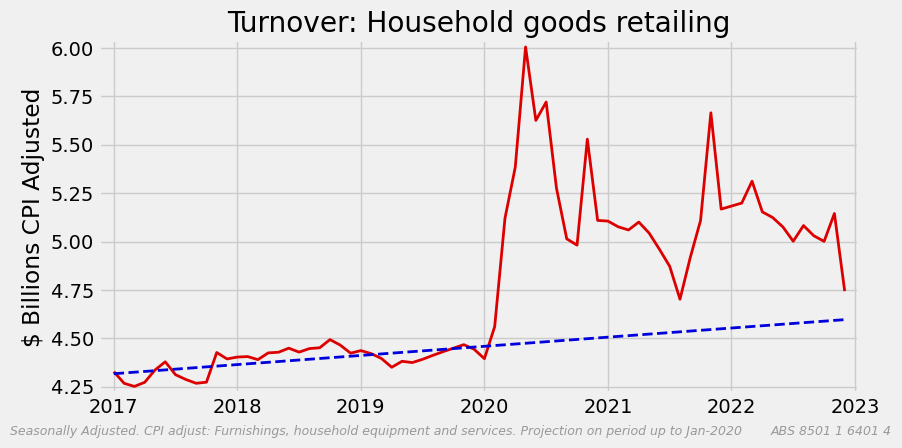

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     277.0
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           3.35e-18
Time:                        23:00:47   Log-Likelihood:                 83.416
No. Observations:                  37   AIC:                            -162.8
Df Residuals:                      35   BIC:                            -159.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0881      0.008    248.234      0.0

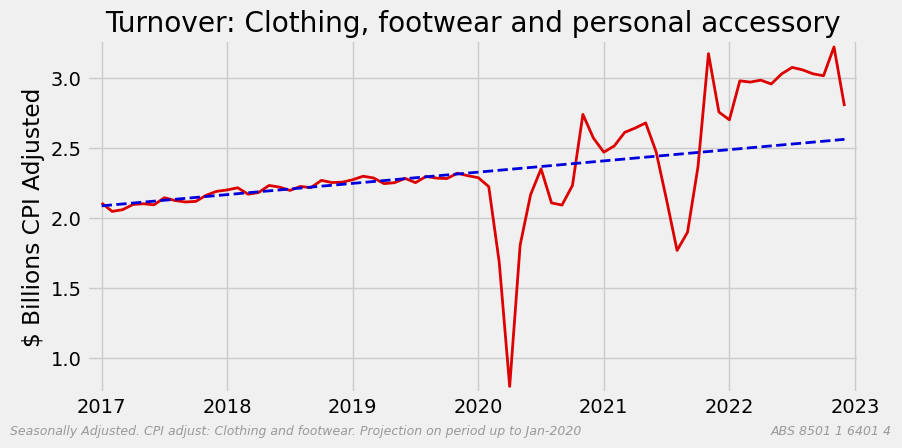

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     36.09
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           7.54e-07
Time:                        23:00:47   Log-Likelihood:                 101.26
No. Observations:                  37   AIC:                            -198.5
Df Residuals:                      35   BIC:                            -195.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4004      0.005    269.691      0.0

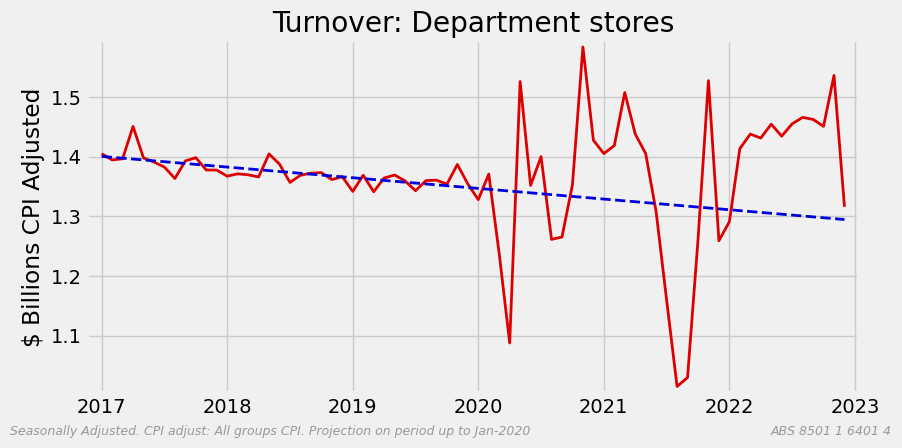

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     74.95
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           3.20e-10
Time:                        23:00:47   Log-Likelihood:                 79.856
No. Observations:                  37   AIC:                            -155.7
Df Residuals:                      35   BIC:                            -152.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3064      0.009    356.991      0.0

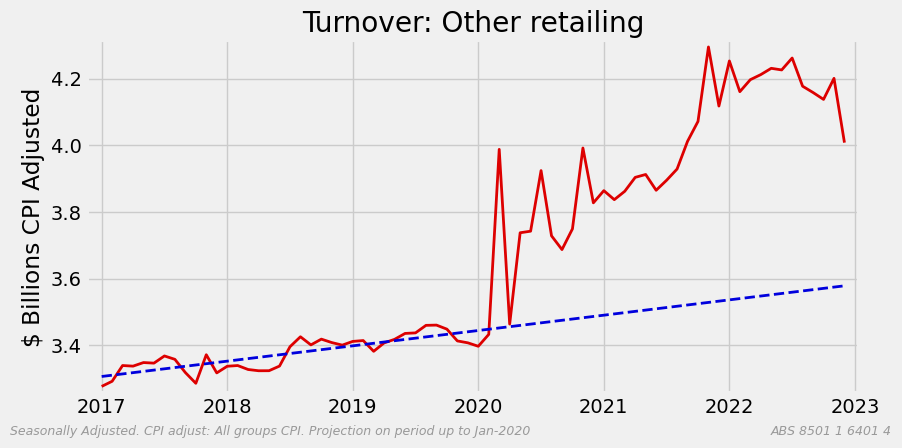

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     73.10
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           4.32e-10
Time:                        23:00:47   Log-Likelihood:                 90.621
No. Observations:                  37   AIC:                            -177.2
Df Residuals:                      35   BIC:                            -174.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2960      0.007    476.058      0.0

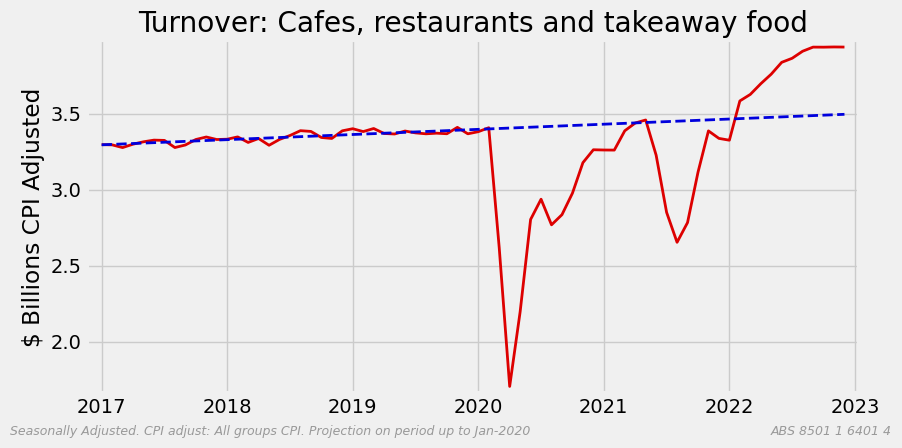

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     239.1
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           3.26e-17
Time:                        23:00:47   Log-Likelihood:                 40.963
No. Observations:                  37   AIC:                            -77.93
Df Residuals:                      35   BIC:                            -74.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.2185      0.026    876.258      0.0

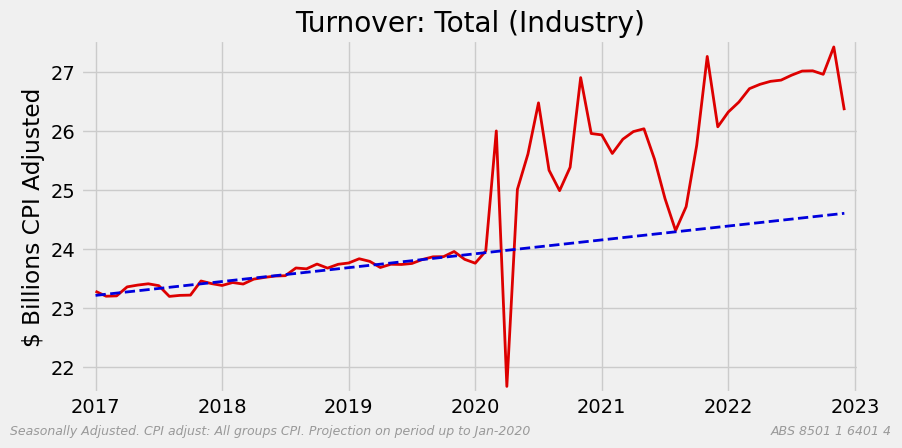

In [5]:
for retail_label, cpi_label in index_map.items():
    id_selector = {
        retail_table: table_col,
        retail_label: did_col,
        retail_type: type_col,
    }
    retail_series_id, retail_units = find_id(retail_meta, id_selector)
    retail_series, retail_units = (
        recalibrate_series(retail_df[retail_series_id], retail_units)
    )
    retail_series.index = pd.PeriodIndex(retail_series.index, freq='M')
    retail_series = retail_series[retail_series.index >= FROM_DATE]

    # plot current prices
    ax = retail_series.plot(lw=2, c='#0000dd')
    title = f'Turnover: {retail_label}'
    lfooter = f'{retail_type}. Current prices. '
    finalise_plot(ax, title, 
                  f'{retail_units}', '', CHART_DIR,
                  rfooter=f'{source} {retail_table}',
                  lfooter=lfooter,
                  #show=True,
                 )
    
    # get inflation index
    index_name = index_map[retail_label]
    id_selector = {
        cpi_table: table_col,
        cpi_label: did_col,
        'Index Numbers': did_col,
    }
    cpi_series_id, cpi_units = find_id(cpi_meta, id_selector)
    cpi_series = cpi_df[cpi_series_id] / 100
    cpi_series.index = pd.PeriodIndex(cpi_series.index, freq='Q')
    cpi_series = cpi_series.resample('M').interpolate(method='linear', pad=None)
    cpi_series = cpi_series[cpi_series.index >= FROM_DATE]
    
    # adjust original seriesproject pre-COVID trend - and plot
    adj_retail_series = retail_series / cpi_series
    
    # project 3-year pre-COVID trend - provides a reference point
    y = adj_retail_series[adj_retail_series.index <= LIN_REGRESS]
    x = np.arange(len(y))
    xx = np.arange(len(adj_retail_series))
    regress_data = pd.DataFrame({
        'y': y.values,
        'x': x,
    })
    model = smf.ols(formula='y ~ x', data=regress_data).fit()
    print(model.summary())
    prediction = (
        pd.Series(xx * model.params['x'] + model.params['Intercept'],
                  index = adj_retail_series.index)
    )
    
    # And plot ...
    ax2 = adj_retail_series.plot(lw=2, c='#dd0000')
    prediction.plot(lw=2, c='#0000dd', ax=ax2, ls='--')
    lfooter = (
        f'{retail_type}. CPI adjust: {cpi_label}. '
        'Projection on period up to Jan-2020'
    )
    finalise_plot(ax2, title, 
                  f'{retail_units} CPI Adjusted', '-CPI-adjusted', CHART_DIR,
                  rfooter=f'{source} {retail_table} {cpi_catalogue_id} {cpi_table}',
                  lfooter=lfooter,
                  show=True,
                 )

## Finished

In [6]:
print('Finished')

Finished
